<a href="https://colab.research.google.com/github/merve-kasap/ViT-implementation-for-the-fMRI-project/blob/main/ViT_implementation_for_the_fMRI_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT Implementation

VIT is implemented already using Huggingface. 

In this issue:

We'll create a notebook which uses HF transformers, and use sample image to perform inference. 
  - Do this for 2 images, making sure to study the length of the inputs, requirements for input to the model, and outputs. (You'll need to find some example images)

Then, repeat this implementation using the ViT Classes directly. This means you'll need to specifically use the feature extractor and the VitForImageClassification (or whatever the correct class name is) to implement the above, but using the specific classes. For this one, make sure to note the key names (as in the keys of a dictionary) of the outputs of the feature extractors, as these are the important inputs to the model.

Make sure to comment about the components of the model, namely:

  feature extractor and how it prepares the inputs
  requirements for feature inputs
  Required inputs to the actual transformer model
  Anything else you find to be important in the context of us using this for fMRI or EEG signals.

# Install Required Libraries

We will start by installing the required libraries for this notebook. We will use the `timm`, `transformers`, and `datasets` libraries in this notebook. `timm` provides a collection of models for computer vision, including ViT, and `transformers` provides access to pre-trained models, including ViT, as well as tools for training and evaluating models. `datasets` provides easy access to common datasets for NLP and computer vision.

We will use the `!pip install` command to install these libraries.


In [ ]:
%%capture
!pip install timm
!pip install transformers datasets

# Import Required Libraries

We will now import the required libraries for this notebook. We will use `os` to access the file system, `matplotlib` to visualize images, `numpy` for numerical computations, `PIL` to work with images, `requests` to download images from the internet, `torch` for tensor operations and to work with the ViT model, `torchvision` to access commonly used datasets and data transforms, `timm` to create the ViT model, and `transformers` to access the ViT feature extractor and classification models.

We will also import `ViTFeatureExtractor` and `ViTForImageClassification` from the `transformers` library. `ViTFeatureExtractor` is used to extract features from images using the ViT model, and `ViTForImageClassification` is the classification model that uses ViT to classify images.


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import requests

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model
from PIL import Image
from io import BytesIO
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Load Transformers Pipeline and Datasets

We will now load the transformers pipeline for image classification using the ViT model. We will use this pipeline to perform inference on the sample images.

We will also load the `load_dataset` and `load_metric` functions from the `datasets` library. These functions will allow us to load the required datasets for this notebook.


In [ ]:
#transformers
from transformers import pipeline
from datasets import load_dataset, load_metric, Dataset

# Prepare Model and Data

We will now prepare the ViT model and data for the pipeline implementation.

First, we will load the ViTForImageClassification model from the `transformers` library using the `create_model` function from the `timm` library. We will specify the model architecture and number of classes for our task.

Next, we will load the `ViTFeatureExtractor` from the `transformers` library. This feature extractor is used to prepare the inputs for the ViT model.

We will then load two sample images for performing inference. We will use `requests` to download the images from the internet and then use `PIL` to open and display the images.

From huggingface:

In [ ]:
dataset = load_dataset("huggingface/cats-image")

cats_image = dataset["test"]["image"][0]

from transformers import AutoImageProcessor, ViTModel
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = image_processor(cats_image, return_tensors="pt")

with torch.no_grad():

    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state

list(last_hidden_states.shape)

  0%|          | 0/1 [00:00<?, ?it/s]

[1, 197, 768]

In the following cell, we will continue preparing the ViT model and data for the pipeline implementation.

We will start by downloading a sample image from the internet using `requests`. We will use this image to test our implementation.

Next, we will load the `AutoImageProcessor` and `ViTForMaskedImageModeling` from the `transformers` library. The `AutoImageProcessor` is used to preprocess the images for use with the ViT model. The `ViTForMaskedImageModeling` is a variant of the ViT model that is used for masked image modeling.

We will then preprocess the image using the `AutoImageProcessor`. We will use the `return_tensors` parameter to get the inputs in PyTorch tensor format.

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

from transformers import AutoImageProcessor, ViTForMaskedImageModeling
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForMaskedImageModeling.from_pretrained("google/vit-base-patch16-224-in21k")

num_patches = (model.config.image_size // model.config.patch_size) ** 2
pixel_values = image_processor(images=image, return_tensors="pt").pixel_values
# create random boolean mask of shape (batch_size, num_patches)
bool_masked_pos = torch.randint(low=0, high=2, size=(1, num_patches)).bool()

outputs = model(pixel_values, bool_masked_pos=bool_masked_pos)
loss, reconstructed_pixel_values = outputs.loss, outputs.logits
list(reconstructed_pixel_values.shape)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForMaskedImageModeling: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForMaskedImageModeling from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForMaskedImageModeling from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForMaskedImageModeling were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['decoder.0.bias', 'embeddings.mask_token', 'decoder.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[1, 3, 224, 224]

From the original ViT paper:
In the following cell, we will prepare the ViT model for performing inference on the sample images.

We will start by specifying the name of the ViT model we want to use, which is `vit_base_patch16_224`. We will also print the device we are using, which is `cuda` if a GPU is available, and `cpu` otherwise.

Next, we will create a ViT model using the `create_model` function from the `timm` library. We will specify the model architecture and load the pre-trained weights.

Finally, we will move the model to the device specified above using the `to` function.

In [ ]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cpu


We will now define the transforms that will be applied to the sample images before passing them through the ViT model.

We will start by specifying the size of the image after resizing, which is `(224, 224)`.

Next, we will specify the mean and standard deviation for normalization. These values are commonly used for pre-trained models and are `(0.5, 0.5, 0.5)` for both mean and standard deviation.

We will then define the transforms using the `transforms` module from the `torchvision` library. We will resize the image to the specified size, convert it to a tensor, and normalize it using the specified mean and standard deviation.

Finally, we will compose these transforms using the `T.Compose` function to create a single transform that can be applied to the sample images.

In [ ]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

# Download ImageNet Labels and Sample Image

In the following cell, we will download the ImageNet labels and a sample image for testing our implementation.

We will start by downloading the ImageNet labels from the internet. These labels will be used to interpret the output of the ViT model.

Next, we will download a sample image of Santorini from the internet. We will use this image to test our implementation.

We will then load the sample image using `PIL` and apply the transforms defined above. We will also unsqueeze the tensor to add an extra dimension for batch size and move the tensor to the device specified above.

Finally, we will suppress the output of this cell using `%%capture` to avoid printing unnecessary information.


In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

# Simple Inference
We will perform end-to-end inference on the sample image of Santorini using the ViT model.

We will pass the preprocessed tensor through the ViT model using the `model` function. The output of the function will be the predicted class probabilities.

Note that the output of the model will be a tensor on the device specified above. If you want to interpret the output or use it for further computations, you may need to move the tensor to the CPU using the `.cpu()` function.

In [ ]:
# end-to-end inference
output = model(img_tensor)

We will start by printing the predicted class label. We will use the `imagenet_labels` dictionary we loaded earlier to map the output of the model to the corresponding class label.

Next, we will visualize the sample image using `matplotlib`. This will allow us to visually verify that the model predicted the correct class.

Note that if the output of the model does not match the expected class label, you may need to debug your implementation or try using a different sample image.

Inference Result:
dome



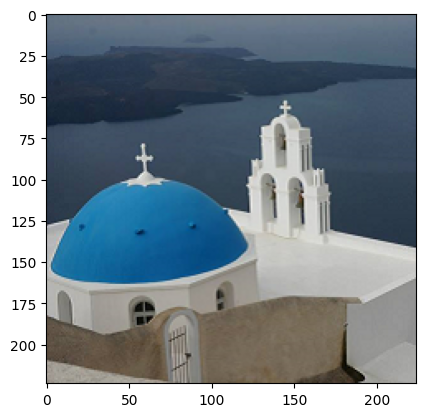

In [ ]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Dig into Vision Transformer

Let's look at the details of the Vision Transformer!

#  1. Split Image into Patches

We will split the input image into patches using the patch embedding convolution.

We will pass the preprocessed tensor through the patch embedding convolution using the `patch_embed` function of the ViT model. The output of the function will be the patches of the image, each of shape `(batch_size, num_patches, embed_dim)`.

We will then print the shape of the input image tensor and the shape of the patch embeddings tensor.

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


# 2. Add Position Embeddings

To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. 
The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

We will use the `pos_embed` attribute of the ViT model to get the position embeddings. The shape of the position embeddings tensor will be `(1, num_patches + 1, embed_dim)`.

Note that the `+1` in the shape of the position embeddings tensor is because the ViT model adds a learnable "class" token to the sequence of embeddings. This token represents the entire image and is used for classification.

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


We will use the cosine similarity between each embedding and all the other embeddings to compute the similarities. We will then reshape the similarities into a 14x14 grid and visualize them using `matplotlib`.

Note that this visualization can help us understand how the position embeddings learn the spatial information in the input image.

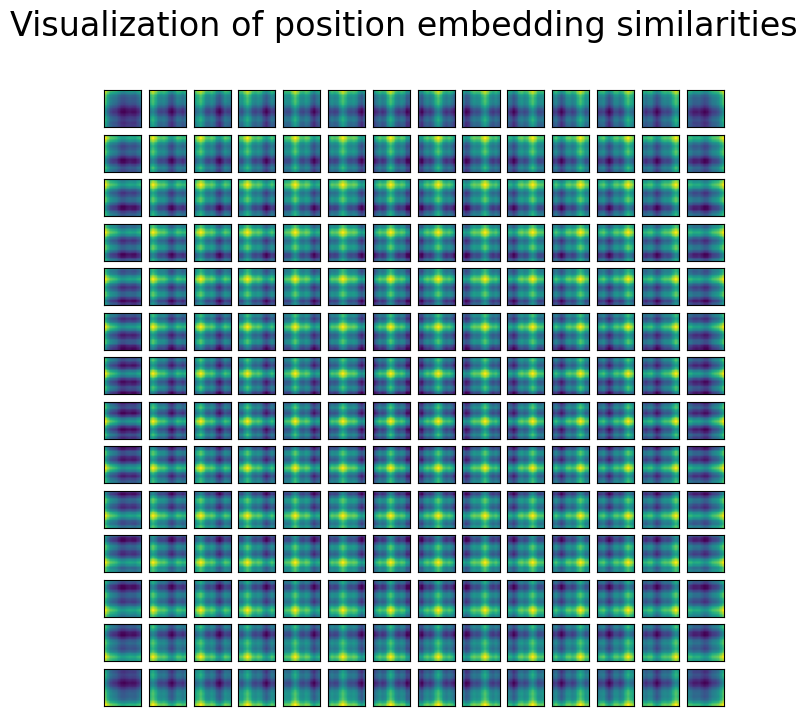

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
We will prepare the input to the transformer layer.

We will prepend a learnable class token to the patch embedding vectors as the 0th vector. We will also add the learnable position embeddings to the patch embedding vectors. A **learnable class token** is prepended to the patch embedding vectors as the 0th vector.
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

We will use the `torch.cat` function to concatenate the class token and the patch embeddings along the second dimension. We will then add the position embeddings to the concatenated tensor.

Finally, we will print the shape of the transformer input tensor. The shape of the tensor should be `(batch_size, num_patches + 1, embed_dim)`.



In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder

### Series Transformer Encoders
We will pass the transformer input through the transformer encoder by using a series of transformer encoders to process the transformer input. We will use the `model.blocks` attribute to get a list of transformer encoder blocks from the ViT model.

We will then loop over the transformer encoder blocks and pass the input through each block. The output of the final transformer encoder block will be passed through a layer normalization layer using the `model.norm` function.

We will then extract the output corresponding to the class token, which should be at position 0 along the second dimension of the tensor. This output will be the final representation of the input image.

Finally, we will print the shape of the final output tensor. The shape of the tensor should be `(batch_size, embed_dim)`.

In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


# 4. MLP (Classification) Head

We will pass the output of the transformer encoder through the MLP (classification) head by using the `model.head` attribute to get the MLP head from the ViT model.

We will then pass the output of the transformer encoder corresponding to the class token, which should be at position 0 along the second dimension of the tensor, through the MLP head using the `model.head` function. The output of the MLP head will be a tensor of shape `(batch_size, num_classes)`. The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.
The 1000-dimension classification result is the output of the whole pipeline.

We will then plot the output of the MLP head using `matplotlib`. This will allow us to visually interpret the output of the model.

Finally, we will print the predicted class label using the `imagenet_labels` dictionary. Note that we will use the `torch.argmax` function to get the index of the maximum value in the output tensor, which corresponds to the predicted class label.



Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 538, label name = dome



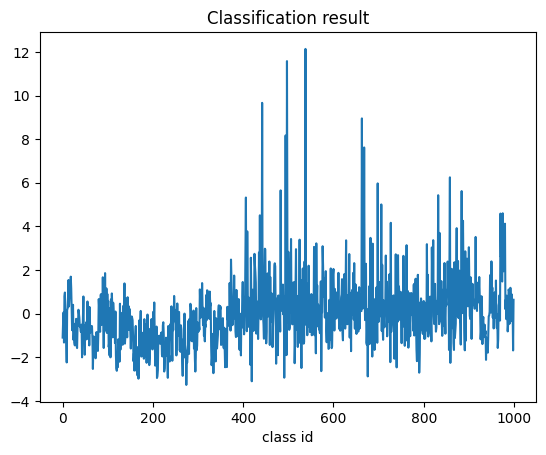

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

# Simple Inference for the second image

Let's load the **cats** image from the huggingface dataset, then:
  
  - prepare it for the ViT model using the AutoImageProcessor, 

  - load the ViT model using ViTForImageClassification, 

  - perform inference, 

  - and print the resulting label name.




/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Inference result: id = 285, label name = Egyptian_cat



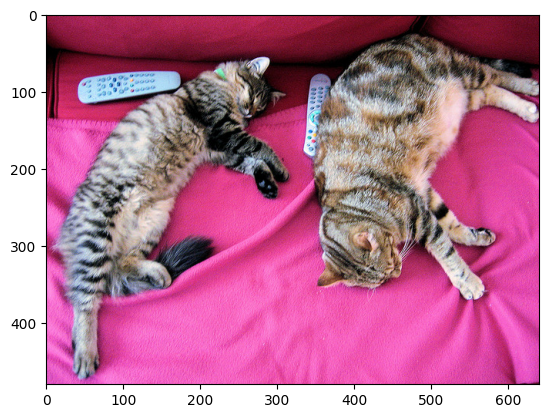

In [ ]:
# Load cats image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
cats_image = Image.open(requests.get(url, stream=True).raw)

# Prepare the image for the model
image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Load the ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

inputs = image_processor(cats_image, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
result_label_id = int(torch.argmax(logits))
print("Inference result: id = {}, label name = {}".format(result_label_id, imagenet_labels[result_label_id]))
plt.imshow(cats_image)
